# A TUTORIAL ON LINEAR REGRESSION

by Sebastian T. Glavind, May, 2020

In [1]:
import numpy as np
import math
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

## The model

In the simplest case of linear regression, sometimes called ordinary linear regression, the scalar output $y$ is assumed to be a linear combination of the inputs $\mathbf{x}$, and the observation errors follow a Gaussian white noise distribution, thus

$$ y | \mathbf{w}, \sigma, \mathbf{x} \sim \mathcal{N}(w_0 + \sum_{m=1}^{M-1} w_m x_m, \sigma^2) = \mathcal{N}(\mathbf{w}^T \mathbf{x}, \sigma^2), $$

where we have augmented the input vector $\mathbf{x}$ with an additional first element, which is always 1, thus $\mathbf{x} = (1, x_1, x_2, ..., x_{M-1})$.

If we now consider a training data set $\mathcal{D}=\{ \mathbf{x}[n], y[n] \}_{n=1}^N = \{ \mathbf{X}, \mathbf{y} \}$, where $\mathbf{X}$ is a $ N \times M $ design matrix and $\mathbf{y}$ is a column vector of the corresponding output observations, the joint likelihood of the training data may be written:

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \prod_{n=1}^N \mathcal{N}(\mathbf{w}^T \mathbf{x}[n], \sigma^2) = \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identity matrix.

## Sample data

### Generative process

In [2]:
w0_true = 4
w1_true = 8
sigma_true = 2

def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

### Training data

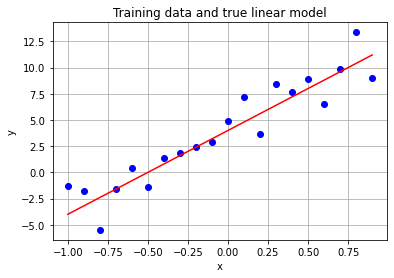

In [3]:
x_tr = np.arange(start=-1, stop=1, step=0.1)
np.random.seed(10) # good seed
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

XX = np.vstack((np.ones(len(x_tr)), x_tr)).T # design matrix (convention Bishop(2006))
nX_tr, mX_tr = XX.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

### Test data

In [4]:
x_te = np.arange(start=-1.25, stop=1.25, step=0.1)
XX_te = np.vstack((np.ones(len(x_te)), x_te)).T # design matrix (convention Bishop(2006))
nX_te, mX_te = XX_te.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

## Maximum likelihood estimation

See e.g. Bishop(2006; Sec.3.1.1) or Murphy(2012; Sec.7.3) for a reference. 

It is usually more convenient to work with the logarithm of the training set likelihood when fitting the model; the log-likelihood of the data thus takes the following form:

$$ \begin{align} 
\log p(\mathbf{y} | \mathbf{w}, \sigma, \mathbf{X}) 
&= \sum_{n=1}^N \log \mathcal{N}(\mathbf{w}^T \mathbf{x}[n], \sigma^2) \nonumber \\ 
&= \sum_{n=1}^N \log \left[ \left(\frac{1}{2\pi\sigma^2}\right)^{1/2} \exp\left( - \frac{1}{2 \sigma^2} (y[n] - \mathbf{w}^T \mathbf{x}[n])^2 \right) \right] \nonumber \\  
&= - \frac{N}{2} \log 2 \pi \sigma^2 - \frac{1}{2 \sigma^2} \sum_{n=1}^N (y[n] - \mathbf{w}^T \mathbf{x}[n])^2 \nonumber \\
&= - \frac{N}{2} \log 2 \pi \sigma^2 - \frac{1}{2 \sigma^2} \text{SSE} \nonumber \\
&= - \frac{N}{2} \log 2 \pi - \frac{N}{2} \log \sigma^2 - \frac{1}{2 \sigma^2} \text{SSE} \nonumber,
\end{align} $$
where $\text{SSE} = \sum_{n=1}^N (y[n] - \mathbf{w}^T \mathbf{x}[n])^2$ is called the sum of squared errors or residual sum of squares ($\text{RSS}$) in some text, and $\frac{1}{N} \text{SSE}$ is the well known mean squared error.

***
Bishop, Christopher M. Pattern recognition and machine learning. Springer, 2006.

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.
***

In [5]:
# elementwise operations
def logLike1(x, y, w0, w1, sigma):
    logLike = 0
    for i,x_val in enumerate(x):
        mu = w0 + w1 * x_val
        logLike += ss.norm(mu,sigma).logpdf(y[i])
    return(logLike)

# vector notation
def logLike2(x, y, w0, w1, sigma):
    mu = w0 + w1 * x
    logLike = sum(ss.norm(mu,sigma).logpdf(y))
    return(logLike)

print( logLike1(x_tr,y_tr, w0_true, w1_true, sigma_true) )
print( logLike2(x_tr,y_tr, w0_true, w1_true, sigma_true) )

-39.36387820045573
-39.36387820045573


### Analytical solution (equivalent to ordinary least squares (OLS) estimation for this case)

See Bishop(2006; Sec.1.2.5 and Sec.3.1.1) or Murphy(2012; Sec.7.3) for a reference.

We first consider how to maximize the likelihood wrt. the regression coefficients $\mathbf{w}$. For this purpose, we can omit the first terms on the right-hand side of log-likelihood above, as it does not depend on $\mathbf{w}$. Also, we note that scaling the log-likelihood by a positive constant does not alter the location of the maximum with respect to $\mathbf{w}$, and so we can ignore the constant ($\frac{1}{2 \sigma^2}$). Finally, instead of maximizing the log-likelihood, we can equivalently minimize the negative log-likelihood. We therefore see that maximizing the likelihood is equivalent, so far as estimation $\mathbf{w}$ is concerned, to minimizing the $\text{SSE}$, which is the procedure of ordinary least squares regression. Thus the $\text{SSE}$ objective function has arisen as a consequence of maximizing the likelihood under the assumption of a Gaussian noise distribution.

The gradient of the log-likelihood function ($\text{SSE}$ part) takes the form

$$ \nabla_\mathbf{w} \log p(\mathbf{y} | \mathbf{w}, \sigma, \mathbf{X}) = - 2 \sum_{n=1}^N (y[n] - \mathbf{w}^T \mathbf{x}[n]) (-\mathbf{x}[n]^T) = 2 \sum_{n=1}^N (y[n] - \mathbf{w}^T \mathbf{x}[n]) \mathbf{x}[n]^T. $$

Now equating to zero and dividing through by 2 we get

$$ \begin{align} 
0 
&= \sum_{n=1}^N y[n] \mathbf{x}[n]^T - \mathbf{w}^T \sum_{n=1}^N \mathbf{x}[n] \mathbf{x}[n]^T \nonumber \\
&= \mathbf{X}^T \mathbf{y} - \mathbf{w}^T \mathbf{X}^T \mathbf{X} \nonumber,
\end{align}$$

and solving for $\mathbf{w}$, we arrive at the MLE/OLE solution, i.e.

$$ \hat{\mathbf{w}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $$

***
Bishop, Christopher M. Pattern recognition and machine learning. Springer, 2006.

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.
***

In [6]:
Wols = np.linalg.pinv(XX).dot(y_tr)
print('MLE parameter estimate: ', Wols)
print('Corresponding likelihood: ', logLike2(x_tr,y_tr, Wols[0], Wols[1], sigma_true))

MLE parameter esitmate:  [4.22885066 7.82823397]
Corresponding likelihood:  -39.19841021128061


We can also maximize the log-likelihood function with respect to the noise variance:

$$ \begin{align} 
\nabla_{\sigma^2} \log p(\mathbf{y} | \mathbf{w}, \sigma, \mathbf{X}) 
&= - \frac{N}{2} \frac{\partial}{\partial \sigma^2}\log \sigma^2 - \frac{1}{2} \text{SSE} \frac{\partial}{\partial \sigma^2} \frac{1}{\sigma^2} \nonumber \\
&= - \frac{N}{2} \left( \frac{1}{\sigma^2} \right) - \frac{1}{2} \text{SSE} \left( - \frac{1}{(\sigma^2)^2} \right) \nonumber\\
&= \frac{1}{\sigma^2} \left( - \frac{N}{2} + \frac{1}{2} \text{SSE} \frac{1}{\sigma^2} \right). \nonumber
\end{align}$$

Now equating to zero and dividing both sides by $2\sigma^2$ we get

$$ 0 = - N + \text{SSE} \frac{1}{\sigma^2} $$

and solving for $\sigma^2$, we arrive at the biased MLE/OLE solution, i.e.

$$ \hat{\sigma}^2 = \frac{1}{N} \text{SSE} = \frac{1}{N} \sum_{n=1}^N ( y[n] - \hat{\mathbf{w}}^T \mathbf{x}[n] )^2, $$

and so we see that the noise variance is given by the residual variance of the target values around the regression function.

In [7]:
mu_mle_tr = (Wols[0] + Wols[1] * x_tr)
SSE_mle = np.sum( (y_tr - mu_mle_tr)**2) 
sigma_mle_bias = np.sqrt(SSE_mle / nX_tr)
print('Biased estimate of standard deviation: ', sigma_mle_bias)

Biased estimate of standard deviation:  1.668136197795402


Note that the above estimator for the noise variance is biased, an unbiased variance estimator is given by

$$ \hat{\sigma}^2 = \frac{1}{N-K} \sum_{n=1}^N ( y[n] - \hat{\mathbf{w}}^T \mathbf{x}[n] )^2, $$

see e.g. Brockhoff et al (2018; Sec.5.3).

***
Brockhoff, Per B. et al. Introduction to Statistics at DTU, DTU, 2018.

***

In [8]:
sigma_mle_unbias = np.sqrt( SSE_mle / (nX_tr-mX_tr))
print('Unbiased estimate of standard deviation: ', sigma_mle_unbias)

Unbiased estimate of standard deviation:  1.75836994413554


The classical standard error of the mean estimate is

$$ \text{se}(\hat{\mu}) = \hat{\sigma}_{\mu} = \frac{\hat{\sigma}}{\sqrt{N}}, $$

where $\hat{\mu} = \mathbf{w}^T \mathbf{x}$, and the corresponding classic 95\% confidence bounds of the mean (latent function) for an unknown standard deviation, i.e. $\mu \pm t_{0.975} \hat{\sigma}_{\mu}$, is plotted below, together with the classic 95\% confidence bounds for the output, i.e. $\mu \pm t_{0.975} \hat{\sigma}$, see e.g. Brockhoff et al (2018, Sec.5.4.1) or Faber (2012; Ch.5). Note that $t_{0.975}$ referres to the $0.975$th quantile value of a t-distribution, which for this case has $N-M$ degrees of freedom. The frequentistic interpretation of the 95\% confidence bounds of the mean is that if we were to repeat the experiment an infinite amount of times and calculate a confidence interval for each experiment, 95\% of those confidence intervals would contain the true parameter value. Thus, there is a 95\% chance that our confidence bound contains the true parameter, see e.g. a cool visualization at: https://seeing-theory.brown.edu/frequentist-inference/index.html#section2.

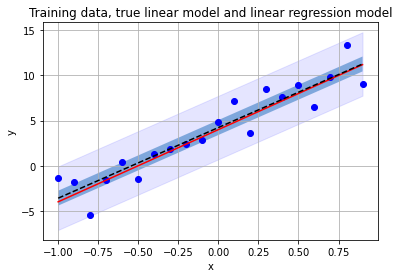

In [9]:
# For the training points
conf_mu_mle = ss.t(df=(nX_tr-mX_tr), loc=0, scale=1).interval(alpha=0.95)[1] * sigma_mle_unbias / np.sqrt(nX_tr)

plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_tr,mu_mle_tr,'--k');
plt.fill_between(x=x_tr, y1=mu_mle_tr - conf_mu_mle, y2=mu_mle_tr + conf_mu_mle, alpha=0.5);
plt.fill_between(x=x_tr, y1=mu_mle_tr - 2*sigma_mle_unbias, y2=mu_mle_tr + 2*sigma_mle_unbias, alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression model');
plt.grid();

We typically define models to be able to predict outcomes of future experiments, thus we need prediction intervals for the predictions at new data points $\mathbf{x}_{\star}$. For this case, we only need to account for the uncertainty in the parameter estimates, when performing a mean prediction $\mu_{\star}$, while we also need to account for the uncertainty of the random error, when predicting the output process $y_{\star}$. 

The prediction bounds for the mean prediction may be defined as

$$ \mu_{\star} \pm t_{(1-\alpha/2)} \hat{\sigma} \sqrt{\frac{1}{N} + \frac{ (\mathbf{x}_{\star} - \bar{\mathbf{x}})^2 }{ \sum_{n=1}^N (\mathbf{x}[n] - \bar{\mathbf{x}})^2 } }, $$

and the prediction bounds for the output is defined as

$$ \mu_{\star} \pm t_{(1-\alpha/2)} \hat{\sigma} \sqrt{1 + \frac{1}{N} + \frac{ (\mathbf{x}_{\star} - \bar{\mathbf{x}})^2 }{ \sum_{n=1}^N (\mathbf{x}[n] - \bar{\mathbf{x}})^2 } }, $$

see e.g. Brockhoff et al (2018; Sec.5.4.1).

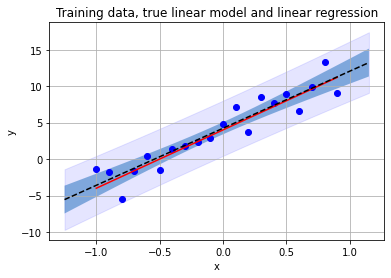

In [10]:
# For the new prediction points
mu_mle_te = Wols[0] + Wols[1] * x_te
Sxx = np.sum( (x_tr - np.mean(x_tr))**2 ) 
Sxx_stars = (x_te - np.mean(x_tr))**2
conf_mu_mle_stars = (ss.t(df=(nX_tr-mX_tr), loc=0, scale=1).interval(alpha=0.95)[1] 
                    * sigma_mle_unbias * np.sqrt( (1/nX_tr) + (Sxx_stars/Sxx) ) )
conf_y_mle_stars = (ss.t(df=(nX_tr-mX_tr), loc=0, scale=1).interval(alpha=0.95)[1] 
                    * sigma_mle_unbias * np.sqrt( 1 + (1/nX_tr) + (Sxx_stars/Sxx) ) )

plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_mle_te,'--k');
plt.fill_between(x=x_te, y1=mu_mle_te - conf_mu_mle_stars, y2=mu_mle_te + conf_mu_mle_stars, alpha=0.5);
plt.fill_between(x=x_te, y1=mu_mle_te - conf_y_mle_stars, y2=mu_mle_te + conf_y_mle_stars, alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

In the figures above, we see that the error bars for the mean prediction at new points gets larger as we move away from the training points, and thus represents increasing uncertainty. By contrast, the approximation $\hat{\mu}$ has constant sized error bars.

### Grid search and likelihood plot

Resulting MLE parameters from grid search:
 4.244897959183673 4.244897959183673
Corresponding likelihood:
 -39.20089309347966


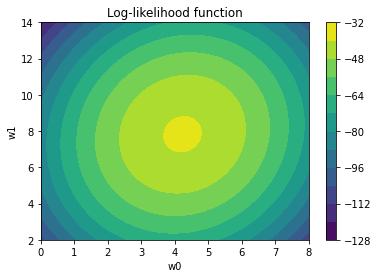

In [11]:
# Define grid
n_grid = 50
w0v = np.linspace(0, 8, n_grid)
w1v = np.linspace(2, 14, n_grid)
w0m, w1m = np.meshgrid(w0v, w1v)

# Evaluate likelihood at grid points
LLm = np.zeros([n_grid,n_grid])
for i in range(w0m.shape[0]):
    for j in range(w0m.shape[1]): 
        LLm[i,j] = logLike2(x_tr,y_tr, w0m[i,j], w1m[i,j], sigma_true)

# Plot results
plt.contourf(w0m, w1m, LLm, levels=10);
plt.colorbar();
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Log-likelihood function');

ind = np.unravel_index(np.argmax(LLm, axis=None), LLm.shape)
print('Resulting MLE parameters from grid search:\n', w0m[ind], w0m[ind])
print('Corresponding likelihood:\n', LLm[ind])

### Batch gradient descent

See Bishop(2006; Sec. 3.1.3) and Theodoridis(2020; Sec. 5.1 - 5.4) for references on gradient decent.

Gradient decent is a simple, gradient-based learning algorithm with the following updating scheme: Based on the current parameters setting, take a small step in the direction of steepest decent, wrt. the objective function, when minimizing e.g. the $\text{SSE}$ objective. The updating rule then becomes 

$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - r \nabla_{\mathbf{w}} \text{SSE}, $$

where $r$ is the learning rate, and the gradient of the $\text{SSE}$ objective wrt. the weight parameters is

$$ \nabla_{\mathbf{w}} \text{SSE} = \sum_{n=1}^N \frac{\partial}{\partial \mathbf{w}} (y[n] - \mathbf{w}^T \mathbf{x}[n])^2 = \sum_{n=1}^N 2 (y[n] - \mathbf{w}^T \mathbf{x}[n]) (-\mathbf{x}[n]^T) = - \sum_{n=1}^N 2 (y[n] - \mathbf{w}^T \mathbf{x}[n]) \mathbf{x}[n]^T. $$

Now in batch gradient decent we use the entire training data set to calculate the gradient at each update. This is in contrast to stochastic gradient decent (SGD), where an update is based on one data point only, and mini-batch SGD, where an update is based on a small subset of the training examples. SGD and mini-batch SGD are implemented in the following sections. Note that mini-batch SGD is commonly used to train modern deep-learning applications (Goodfellow et al.,2016). 

***
Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

Theodoridis, Sergios. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.

Goodfellow, I., Bengio, Y., and Courville, A., Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.
***

In [12]:
# Derivative function, see references (and lecture notes on gradient ascent)
def grad_func(x, y, W):
    gf = 0
    if x.ndim == 0: # iff scalar input
        mu = W[0] + W[1] * x
        gf = 2 * ( y - mu ) * np.array([1, x]) # neg. grad of SSE, see Theodoridis(2020), Eq. (5.6) and (5.34)
    else: # iff vector input
        for i in range(len(x)):
            mu = W[0] + W[1] * x[i]
            gf += 2 * ( y[i] - mu ) * np.array([1, x[i]]) # neg. grad of SSE, see Theodoridis(2020), Eq. (5.6) and (5.34)
    return(gf)

# Derivative function (efficient implementation (vectorized))
def grad_func2(XX,y,W):
    gf = 2 * (XX.T.dot(y) - W.T.dot(XX.T.dot(XX))) # neg. grad of SSE, see Theodoridis(2020), Eq. (5.6) and (5.34)
    return(gf)

print(grad_func(x_tr, y_tr, np.array([4, 8])))
print(grad_func2(XX, y_tr, np.array([4, 8])))

[ 9.49755831 -2.75936615]
[ 9.49755831 -2.75936615]


In [13]:
# Optimization
W1 = np.array([7,12])  # We start the search at [7,12]
gamma0 = 0.01  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_epochs = 1000  # Maximum number of runs through the training set

ii=0
for _ in range(max_epochs):
#     gamma = gamma0
    gamma = gamma0 * np.exp(-0.01*ii) # temporing
    W0 = W1
    W1 = W0 + gamma * grad_func(x_tr, y_tr, W0)
    
    ii += 1
    step = np.sqrt((W1 - W0).dot((W1 - W0)))
    if abs(step) <= precision:
        break

print("Maximum at ", W1, "based on", ii, "iterations")
print('Likelihood: ', logLike2(x_tr,y_tr, W1[0], W1[1], sigma_true))

Maximum at  [4.22886839 7.8284712 ] based on 122 iterations
Likelihood:  -39.19841025815


### Stochatic gradient descent (on-line)

See Bishop(2006; Sec. 3.1.3) and Theodoridis(2020; Sec. 5.1 - 5.4) for references on gradient decent.

In [14]:
# Optimization
W1 = np.array([7,12], dtype=np.float64)  # We start the search at [7,12]
gamma0 = 0.01  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_epochs = 1000  # Maximum number of runs through the training set

ii=0
for _ in range(max_epochs):
    W0 = W1.copy()
    gamma = gamma0 * np.exp(-0.01*ii) # temporing
    
    for i in range(nX_tr):
        rand_ind = np.random.randint(0,nX_tr)
        W1 += gamma * grad_func(x_tr[rand_ind], y_tr[rand_ind], W1)
    
    ii += 1
    step = np.sqrt((W1 - W0).dot((W1 - W0))); # could potentially go inside the nested loop with a modified criteria
    if abs(step) <= precision:
        break

print("Maximum at ", W1, "based on", ii, "iterations")
print('Likelihood: ', logLike2(x_tr,y_tr, W1[0], W1[1], sigma_true))

Maximum at  [4.2708773 7.8857064] based on 671 iterations
Likelihood:  -39.20498829417596


### Mini-batch stochastic gradient descent

See Bishop(2006; Sec. 3.1.3) and Theodoridis(2020; Sec. 5.1 - 5.4) for references on gradient decent.

In [15]:
# Optimization
W1 = np.array([7,12], dtype=np.float64)  # We start the search at [7,12]
gamma0 = 0.01  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_iters = 1000  # Maximum number of iterations
batch_size = 5 # Mini-batch size

ii=0
n_batches = int(nX_tr/batch_size)
for _ in range(max_iters):
    W0 = W1.copy()
    gamma = gamma0 * np.exp(-0.01*ii) # temporing
    indices = np.random.permutation(nX_tr)
    xx_perm = x_tr[indices]
    yy_perm = y_tr[indices]
    for i in range(0,nX_tr,batch_size):
        W1 += gamma * grad_func(xx_perm[i:i+batch_size], yy_perm[i:i+batch_size], W1)
    
    ii += 1
    step = np.sqrt((W1 - W0).dot((W1 - W0))); # could potentially go inside the nested loop with a modified criteria
    if abs(step) <= precision:
        break

print("Maximum at ", W1, "based on", ii, "iterations")
print('Likelihood: ', logLike2(x_tr,y_tr, W1[0], W1[1], sigma_true))

Maximum at  [4.22859485 7.82754232] based on 244 iterations
Likelihood:  -39.19841073128382


## Bayesian inference

See Gelman et al (2013), ch. 14.

In the simplest case, sometimes called ordinary linear regression, the observation errors are
independent and have equal variance; in vector notation,

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identity matrix, and $\mathbf{X}$ is a $ N \times K $ design matrix.

First, we determine the posterior distribution for $\mathbf{w}$, conditional on $\sigma^2$; and second, the marginal
posterior distribution for $\sigma^2$. That is, we factor the joint posterior distribution for $\mathbf{w}$ and $\sigma^2$
as

$$ p(\mathbf{w}, \sigma^2 | \mathcal{D}) = p(\mathbf{w} | \sigma^2, \mathcal{D}) p(\sigma^2 | \mathcal{D}) $$.

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

### Analytical solution

See Gelman et al (2013), ch. 14.

In the normal regression model, a convenient (standard) noninformative prior distribution is uniform
on ($\mathbf{w}$, $\log \sigma $) or, equivalently,

$$ p(\mathbf{w}, \sigma^2) \propto \sigma^{-2} $$

This is also called a Jeffreys prior, see e.g. Marin&Robert(2014).

The conditional posterior distribution of the (vector) parameter $\mathbf{w}$, given $\sigma^2$, is the exponential of a quadratic form in $\mathbf{w}$, i.e. normal. We use the notation

$$ \mathbf{w}| \sigma^2, \mathcal{D} \sim \mathcal{N}(\mu_{w}, V_w\sigma), $$

where

$$ \mu_w = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $$

and

$$ V_w = (\mathbf{X}^T \mathbf{X})^{-1} $$

The marginal posterior distribution of $\sigma^2$ can be written as

$$ p(\sigma^2 | \mathcal{D}) = \frac{p(\mathbf{w}, \sigma^2 | \mathcal{D})}{\mathbf{w}| \sigma^2, \mathcal{D}} =\text{Inv-}\chi^2(N-M, s^2), $$

where 

$$ s^2 = \frac{1}{N-K} (\mathbf{y} - \mathbf{X}\mu_w)^T (\mathbf{y} - \mathbf{X}\mu_w) $$

Note that the marginal posterior distribution of $ \mathbf{w}|\mathbf{y} $, averaging over $\sigma$, is multivariate t with $N−M$ degrees of freedom, but we rarely use this fact in practice when drawing inferences by simulation, since to characterize the joint posterior distribution we can draw simulations of $\sigma$ and then $ \mathbf{w}|\sigma $.

Note also that inverse-gamma (used later) and inverse-chi2 are equivalent, they just use different parametrization, see e.g. https://en.wikipedia.org/wiki/Scaled_inverse_chi-squared_distribution .

#### Parameters of weight posterior

In [16]:
V_w_pos = np.linalg.inv( XX.T.dot(XX) )
mu_w_pos = V_w_pos.dot(XX.T).dot(y_tr)
Sig_w_pos = V_w_pos * sigma_true**2
print('Mean, thus MAP etsimate, of parameters:\n', mu_w_pos)
print('Variance, assuming a fixed noise parameter, of parameters:\n',Sig_w_pos)

Mean, thus MAP etsimate, of parameters:
 [4.22885066 7.82823397]
Variance, assuming a fixed noise parameter, of parameters:
 [[0.20150376 0.03007519]
 [0.03007519 0.60150376]]


#### Plot of weight distribution and coarse grid estimate of MAP parameters

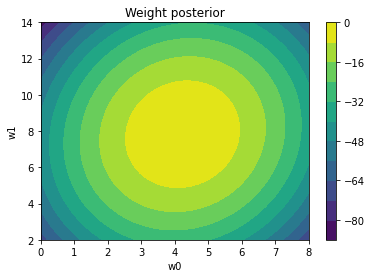

In [17]:
W_dist_pos = ss.multivariate_normal(mean=mu_w_pos, cov=Sig_w_pos)

W_logpos = np.zeros([n_grid,n_grid])
for i in range(w0m.shape[0]):
    for j in range(w0m.shape[1]): 
        W_logpos[i,j] = W_dist_pos.logpdf([w0m[i,j], w1m[i,j]])
        
plt.contourf(w0m, w1m, W_logpos, levels=10);
plt.colorbar();
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Weight posterior');

In [18]:
ind = np.unravel_index(np.argmax(W_logpos, axis=None), W_logpos.shape)
print('Resulting MAP parameters from grid search:\n', w0m[ind], w1m[ind])
print('Corresponding posterior density:\n', W_logpos[ind])

Resulting MAP parameters from grid search:
 4.244897959183673 7.877551020408163
Corresponding posterior density:
 -0.7814797456174003


#### Parameters of noise posterior 

In [19]:
s_sig_pos = np.sqrt( ( y_tr - XX.dot(mu_w_pos) ).T.dot( (y_tr - XX.dot(mu_w_pos)) ) / (nX_tr - mX_tr) ) # Two free parameters (columns of design matrix)
print('Noise parameter:\n', s_sig_pos)

Noise parameter:
 1.7583699441355403


#### Posterior predictive distribution

The posterior predictive distribution of unobserved data, $p(y_{\star}|x_{\star},\mathcal{D})$, has two components of uncertainty: (1) the fundamental  ariability of the model, represented by the variance $\sigma^2$ in $y$ not accounted for by $\mathbf{X}\mathbf{w}$, and (2) the posterior uncertainty in $\mathbf{X}$ and $\sigma$ due to the finite sample size of $\mathcal{D}$; to draw a random sample $y_{\star}$ from its posterior predictive distribution, we first draw $(\mathbf{w},\sigma)$ from their joint posterior distribution, then draw $y_{\star} \sim \mathcal{N}(x_{\star}\mathbf{w}, \sigma^2 \mathbf{I})$.

The normal linear model is simple enough that we can also determine the posterior predictive distribution analytically.
Deriving the analytic form is not necessary -- we can easily draw $(\mathbf{w},\sigma)$ and then $y_{\star}$, as described above -- however, we can gain useful insight by studying the predictive uncertainty analytically.

We first consider the conditional posterior predictive distribution, $p(y_{\star}|x_{\star},\mathcal{D})$, then average over the posterior uncertainty in $\sigma | \mathcal{D}$. Given $\sigma$, the future observation $y_{\star}$ has a normal distribution, and we derive its mean by averaging over $\mathbf{w}$ using

$$ \mathbb{E}[y_{\star}|\sigma] = \mathbb{E}[ \mathbb{E}[ y_{\star}|\mathbf{w},\sigma ] | \sigma ] = \mathbb{E}[ x_{\star}\mathbf{w}|\sigma ] = x_{\star}\mathbf{w},$$

where we have suppresed the dependence on $(x_{\star}\mathcal{D})$ on the expressions above. The inner expectation averages over $y_{\star}$, conditional on $\mathbf{w}$, and the outer expectation averages over $\mathbf{w}$.

Similarly, we can derive $\mathbb{V}[y_{\star}|\sigma]$, see Gelman et al(2013; Eq. 14.9), to arrive at

$$ (\mathbf{I} + x_{\star} V_{w} x_{\star}^T  ) \sigma^2 $$

Thus, Given $\sigma$, the future observations have a normal distribution with mean $x_{\star}\mathbf{w}$, which does not depend on $\sigma$, and (co)variance that is proportional to $\sigma^2$. To complete the determination of the posterior predictive distribution, we must average over the marginal posterior distribution of $\sigma^2$. The resulting posterior predictive distribution, $p(y_{\star}|\mathcal{D})$, is multivariate t with center $\mathcal{x}_{\star} \mathcal{w}$, squared scale matrix $(\mathbf{I} + x_{\star} V_{w} x_{\star}^T  ) s^2$, and $N−M$ degrees of freedom.

Note that posterior predictive variances have two terms, i.e.
$\mathbf{I} \sigma^2$ and $\mathbf{I} s^2$, and $(x_{\star} V_{w} x_{\star}^T  ) \sigma^2$ and $(x_{\star} V_{w} x_{\star}^T  ) s^2$, representing sampling variation, and uncertainty due to uncertainty about $\mathbf{w}$, respectively.

In [20]:
mu_y_pos = XX_te.dot(mu_w_pos)
Sig_y_pos = ( np.eye(nX_te) + XX_te.dot(V_w_pos).dot(XX_te.T) ) * sigma_true
Sig_f_pos = ( XX_te.dot(V_w_pos).dot(XX_te.T) ) * sigma_true

To complete the posterior predictive distribution for a unknown $\sigma$, we must average over the marginal posterior distribution of $\sigma^2$ (above). The resulting posterior predictive distribution, $p(y_{\star})$, is multivariate t with center $x_{\star}\mathbf{w}$, squared scale matrix $(\mathbf{I} + x_{\star} V_{w} x_{\star}^T)s^2 $, and $N − M$ degrees of freedom.

In [21]:
mu_y_pos_ = mu_y_pos
Sig_y_pos_ = ( np.eye(nX_te) + XX_te.dot(V_w_pos).dot(XX_te.T) ) * s_sig_pos
Sig_f_pos_ = (XX_te.dot(V_w_pos).dot(XX_te.T) ) * s_sig_pos
df_y_pos_ = nX_tr - mX_tr

#### Prediction intervals

Bayesian credible interval for the mean (latent function) and output:

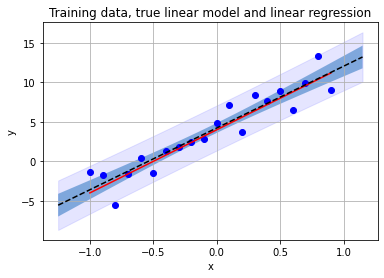

In [22]:
conf_f_exact = ss.t(df=df_y_pos_, 
                    loc=mu_y_pos_, 
                    scale=np.sqrt( np.diag(Sig_f_pos_) )
                   ).interval(0.95)
conf_y_exact = ss.t(df=df_y_pos_, 
                    loc=mu_y_pos_, 
                    scale=np.sqrt( np.diag(Sig_y_pos_) )
                   ).interval(0.95)

plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_y_pos_,'--k');
plt.fill_between(x=x_te, y1=conf_f_exact[0], y2=conf_f_exact[1], alpha=0.5);
plt.fill_between(x=x_te, y1=conf_y_exact[0], y2=conf_y_exact[1], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

As mentioned, the variance in an output prediction ($y_{\star}$) depends on two terms: the variance of the observation noise ($\sigma^2$) and the variance in the parameters $(\mathbf{V}_w)$. The latter translates into variance about observations in a way which depends on how close $\mathbf{x}_{\star}$ is to the training data $\mathcal{D}$. In the figure above, we see that the error bars for the mean prediction, reflecting the uncertainty in $\mathbf{V}_w$, gets larger as we move away from the training points, and thus represents increasing uncertainty. By contrast, the approximation $\hat{\mu}$ has constant sized error bars, as it is apparent from the previous section on MLE estimation.

### MCMC: Gibbs sampling 

See Gelman et al (2013), ch. 11-12 for a reference on Gibbs sampling.

In this section, we will consider the simple model from above, and perform learning using Gibbs sampling. For this case, the needed conditional distributions become

$$ \begin{align}
\mathbf{w}|\sigma^2 &\sim \mathcal{N}(\mu_w, \sigma^2 V_w) \nonumber \\
\sigma^2|\mathbf{w} &\sim \text{Inv-Gam}( (N-M)/2, ( (\mathbf{y} - \mathbf{X}\mu_w)^T (\mathbf{y} - \mathbf{X}\mu_w)  )/2 ) \nonumber
\end{align}$$

where $\mu_w = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$ and $V_w = (\mathbf{X}^T \mathbf{X})^{-1}$ as in the previous section. This is actually an instance of block Gibbs sampling, as the regression coefficients $\mathbf{w}$ are sampled jointly. The joint Gaussian distribution for $\mathbf{w}$ may be split op into uniform Gaussian distributions by use the standard rules for conditioning Gaussian distributed random variables, which will yield the same result of the simulation at convergence; see the numerical example below.

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.

Marin, JM and Roberts, C, "Bayesian Essentials with R", 2014.
***

In [23]:
sigma2_gib = sigma_mle_unbias**2 # + 10 # pertube to se whether it still succede
w0_gib = np.mean(y_tr) # + 10 # pertube to se whether it still succede
x2inv_gib = np.linalg.inv(XX.T.dot(XX)) 
np.random.seed(1001)

In [24]:
n_samp_gib = 10**3
samp_gib = np.zeros((n_samp_gib, mX_tr+1))
for t in range(n_samp_gib):
    # Although there are exact ways to draw directly from the joint posterior distribution of w, i.e.
#     w_gib = ss.multivariate_normal(mean = Wols, cov= sigma2_gib*x2inv_gib).rvs(1) # corr. block gibbs sampling,
    # we make use of Gibbs sampling to simulate a Markov chain that will converge to a bivariate Normal
    Sig_w = sigma2_gib*x2inv_gib
    w1_gib = (ss.norm(loc = Wols[1] + (Sig_w[1,0]/Sig_w[0,0])*(w0_gib-Wols[0]), 
                      scale = np.sqrt(Sig_w[1,1] - (Sig_w[1,0]/Sig_w[0,0])*Sig_w[0,1])).rvs(1)) # Bishop(2006; Sec.2.3.1)
    w0_gib = (ss.norm(loc = Wols[0] + (Sig_w[0,1]/Sig_w[1,1])*(w1_gib-Wols[1]), 
                      scale = np.sqrt(Sig_w[0,0] - (Sig_w[0,1]/Sig_w[1,1])*Sig_w[1,0])).rvs(1)) # Bishop(2006; Sec.2.3.1)
    w_gib = np.concatenate([w0_gib,w1_gib])
    error2_gib = (y_tr - XX.dot(w_gib)).T.dot((y_tr - XX.dot(w_gib)))
    sigma2_gib = ss.invgamma(a=(nX_tr - mX_tr )/2, scale=error2_gib/2 ).rvs(1) # mX in one larger than p and alreaddy accounts for the -1
    # For parametrization in scikit.stats see e.g. http://spencerlyon.com/2015/01/07/canonical-probability-distributions-in-python/
    samp_gib[t,:] = np.concatenate([w_gib,sigma2_gib])

#### Post-precessing

Sort samples; first half is regarded as burn-in.

In [25]:
samp_gib0 = samp_gib[0:round(n_samp_gib/2),:] # first half - burn-in
samp_gib1 = samp_gib[round(n_samp_gib/2):n_samp_gib,:] # second half 

#### Sample statistics and visualization

Weights:

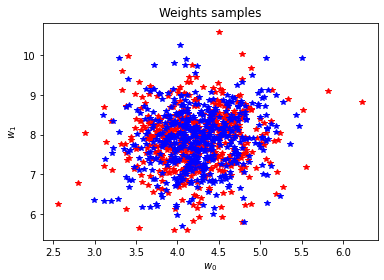

In [26]:
plt.plot(samp_gib0[:,0],samp_gib0[:,1],'*r');
plt.plot(samp_gib1[:,0],samp_gib1[:,1],'*b');
plt.xlabel('$w_0$');
plt.ylabel('$w_1$');
plt.title('Weights samples');

NOTE: It appears that we have instantaneous mixing, and thus we will use all samples in the following (not generally recommended and convergence should be verified quantitatively, see PyMC implementation).

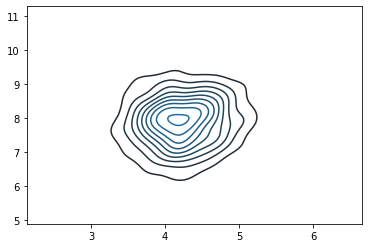

In [27]:
sns.kdeplot(samp_gib[:,0], samp_gib[:,1],n_levels=10);

In [28]:
np.mean(samp_gib[:,0:2],axis=0) # thinning (np.mean(samp_gib[0::1,0:2],axis=0))

array([4.23150727, 7.86995175])

In [29]:
np.cov(samp_gib[:,0:2].T) # thinning (np.cov(samp_gib[0::1,0:2].T))

array([[0.20115663, 0.03390185],
       [0.03390185, 0.56854351]])

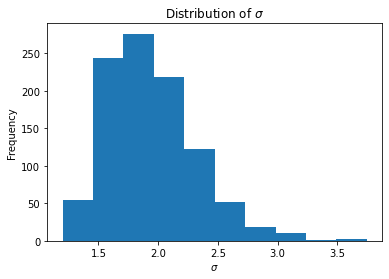

In [30]:
plt.hist(np.sqrt(samp_gib[:,2]));
plt.xlabel('$\sigma$');
plt.ylabel('Frequency');
plt.title('Distribution of $\sigma$');

In [31]:
np.mean(np.sqrt(samp_gib[:,2]))

1.944975806998515

Note also that the Jeffreys prior estimate of $\sigma^2$ is larger (and thus more pessimistic) than both the maximum likelihood estimate $\text{SSE}/N$ and the classical unbiased estimate $\text{SSE}/(N − M)$.

#### Prediction intervals

Bayesian credible interval for the mean (latent function):

In [32]:
f_pred_gib = samp_gib1[:,0:2].dot(XX_te.T)
y_pred_gib = f_pred_gib + np.random.normal(scale=np.sqrt(samp_gib1[:,2])).reshape([-1,1])
mu_pred_gib = np.mean(f_pred_gib,axis=0)
cf_pred_f_gib= np.quantile(f_pred_gib,q=[0.025, 0.975],axis=0)
cf_pred_y_gib= np.quantile(y_pred_gib,q=[0.025, 0.975],axis=0)

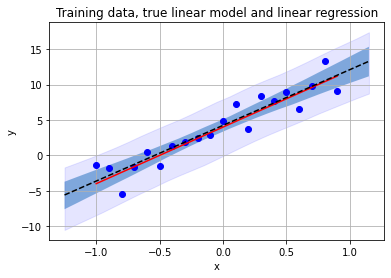

In [33]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_pred_gib,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f_gib[0,:], y2=cf_pred_f_gib[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y_gib[0,:], y2=cf_pred_y_gib[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

### MCMC: Metropolis algorithm

See Gelman et al (2013), ch. 11-12 for a reference on the Metropolis algorithm.

In this section, we consider a model that is a little more involved than the simple model we have considered in the previous sections on Bayesian inference. The main source of inspiration for the model is Drugowitsch(2013) accompanied by Murphy(2012; Sec.21.5.2), thus we will also solve this problem using variational inference, see the next section.

In this example, we will consider the following probabilistic modeling of the parameters:

$$ p(\mathbf{w},\beta|\alpha) = \mathcal{N}(\mathbf{w} | 0, (\beta \mathbf{A})^{-1} ) \text{Gam}(\beta | a_0, b_0 ) $$

$$ p(\mathbf{\alpha}) = \prod_{m} \text{Gam}(\alpha_m|c_0,d_0), $$

where we consider the precision instead of the noise variance for notational convenience, thus

$$ \alpha_m = \frac{1}{\sigma_{w,m}^2} \quad \text{and} \quad \beta = \frac{1}{\sigma^2}. $$

Note that Drugowitsch(2013) uses $\tau$ for the output precision. The posterior $ p(\mathbf{w},\mathbf{\alpha},\beta|\mathcal{D}) $ is not analytically tractable, thus we adapt a Metropolis algorithm to generate samples from the distribution. 

Recall that the parameter posterior is defined through Bayes' rule as 

$$p(\boldsymbol\theta|\mathcal{D}) = \frac{ p(\mathbf{y},\boldsymbol\theta|\mathbf{x}) }{ p(\mathbf{y})}, $$

but we will work with the unnormalized version, i.e.

$$p(\boldsymbol\theta|\mathcal{D}) \propto p(\mathbf{y},\boldsymbol\theta|\mathbf{x}), $$

to avoid calculating the always troubling normalizing constant $\mathbf{y}$. The unnormalized posterior for this case takes the following form:

$$ p(\mathbf{w},\mathbf{\alpha},\beta|\mathcal{D}) \propto \mathcal{N}(\mathbf{y} | \mathbf{X}\mathbf{w},\sigma^2\mathbf{I}) \mathcal{N}(\mathbf{w} | 0, (\beta \mathbf{A})^{-1} ) \text{Gam}(\beta | a_0, b_0 ) \prod_{m} \text{Gam}(\alpha_m|c_0,d_0). $$

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.

Drugowitsch, J, ''Variational Bayesian inference for linear and logistic regression'', 2013, (available at https://arxiv.org/pdf/1310.5438.pdf)
***

In [34]:
# This function calculates the unnormalized posterior for theta, i.e. p(theta|D) = p(y,theta|x)/p(y)
def log_pos_metropolis(x,y,w,beta,A,a0,b0,c0,d0):
    mu = w[0] + w[1] * x
    logPos = (sum( ss.norm( loc = mu, scale= np.sqrt(1/beta) ).logpdf(y) ) 
              + ss.multivariate_normal(mean = np.zeros(len(w)), cov=np.linalg.inv(beta*A)).logpdf(w)
              + ss.gamma(a = a0, scale = b0).logpdf(beta) 
              + sum( ss.gamma(a = c0, scale = d0).logpdf(np.diag(A)) )
             ) 
    return(logPos)

In [35]:
a0, b0, c0, d0 = 2,2,2,2 # Hyper-parameters (recommendation stan manual)
log_alp_init_vec = np.log( np.ones(2)*1e-4 ) # NOTE: This is sampled in log-scale!
log_beta_init_met = np.log(1/(sigma_true**2)) # NOTE: This is sampled in log-scale!
w0_init_met = Wols[0]
w1_init_met = Wols[1]

In [36]:
np.random.seed(42)
n_samp_met = 10**3
eps_met = 1e-8
samp_met = np.zeros([n_samp_met, 5])
samp_met[0,:] = np.concatenate([np.array([w0_init_met, w1_init_met,log_beta_init_met]), log_alp_init_vec])
lp_cur_met = log_pos_metropolis(x=x_tr, y=y_tr, 
                                w=samp_met[0,0:2], beta=np.exp(samp_met[0,2]), A=np.diag( np.exp(samp_met[0,3:5]) ), 
                                a0=a0, b0=b0, c0=c0, d0=d0)

In [37]:
counter=0
for t in range(1,n_samp_met,1):
    x_pro_met = ss.multivariate_normal( mean = samp_met[t-1,:], cov = np.abs(np.diag((samp_met[0,:]*0.025)) + eps_met) ).rvs(1)
    lp_pro_met = log_pos_metropolis(x=x_tr, y=y_tr,
                                    w=x_pro_met[0:2], beta=np.exp(x_pro_met[2]), A=np.diag( np.exp(x_pro_met[3:5]) + eps_met), 
                                    a0=a0, b0=b0, c0=c0, d0=d0)
    ratio_pro_met = np.min( [(lp_pro_met - lp_cur_met ), 0] )
    if np.log(np.random.uniform()) < ratio_pro_met: 
        counter += 1
        samp_met[t,:] = x_pro_met
        lp_cur_met = lp_pro_met
    else:
        samp_met[t,:] = samp_met[t-1,:]

print('Acceptance ratio: ', counter/n_samp_met) 

Acceptance ratio:  0.529


#### Post-precessing

Sort samples; first half is regarded as burn-in

In [38]:
samp_met0 = samp_met[0:round(n_samp_met/2),:] # burn-in
samp_met1 = samp_met[round(n_samp_met/2):n_samp_met,:] # without burn-in

#### Sample statistics and visualization

Weights:

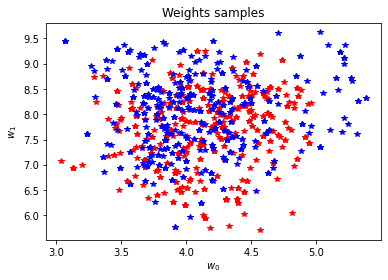

In [39]:
plt.plot(samp_met0[:,0],samp_met0[:,1],'*r');
plt.plot(samp_met1[:,0],samp_met1[:,1],'*b');
plt.xlabel('$w_0$');
plt.ylabel('$w_1$');
plt.title('Weights samples');

It appears that the algorithm has mixing (convergence should be verified quantitatively, see PyMC implementation).

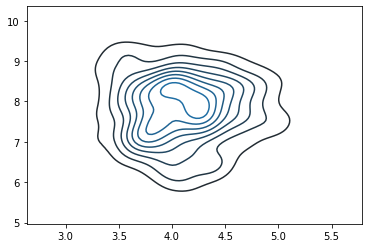

In [40]:
sns.kdeplot(samp_met[:,0], samp_met[:,1],n_levels=10);

In [41]:
np.mean(samp_met1[:,0:2],axis=0) # 1e5: array([4.09285858, 7.56867304]) but still only one chain and no thinning

array([4.08393096, 7.97084406])

Output standard deviation:

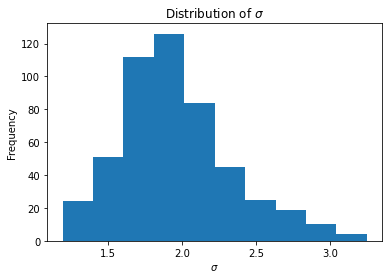

In [42]:
plt.hist(np.sqrt(1/np.exp(samp_met1[:,2])));
plt.xlabel('$\sigma$');
plt.ylabel('Frequency');
plt.title('Distribution of $\sigma$');

In [43]:
np.mean(np.sqrt(1/np.exp(samp_met1[:,2])))

1.9510310796255537

Weight prior, i.e. alpha's

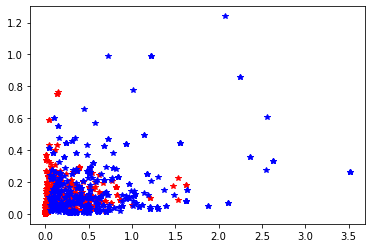

In [44]:
plt.plot(np.exp(samp_met0[:,3]), np.exp(samp_met0[:,4]),'*r');
plt.plot(np.exp(samp_met1[:,3]), np.exp(samp_met1[:,4]),'*b');

In [45]:
np.mean(np.exp(samp_met1[:,3:5]),axis=0) # N=1e5: array([0.57201294, 0.19809036]) but still only one chain and no thinning

array([0.56450603, 0.15501509])

#### Prediction intervals

Bayesian credible interval for the mean (latent function) and output process:

In [46]:
f_pred_met = samp_met1[:,0:2].dot(XX_te.T)
y_pred_met = f_pred_met + np.random.normal(scale=np.sqrt(1/np.exp(samp_met1[:,2]))).reshape([-1,1])
mu_pred_met = np.mean(f_pred_met,axis=0)
cf_pred_f_met= np.quantile(f_pred_met,q=[0.025, 0.975],axis=0)
cf_pred_y_met= np.quantile(y_pred_met,q=[0.025, 0.975],axis=0)

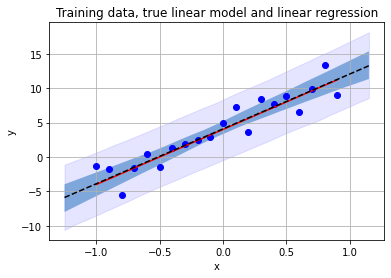

In [47]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_pred_met,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f_met[0,:], y2=cf_pred_f_met[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y_met[0,:], y2=cf_pred_y_met[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

### Variational inference 

See e.g. Bishop(2006; Sec.10.3) and especially Theodoridis(2020; Sec.13.3) for a general reference on variational inference (VI).

In this section, we will consider the probabilistic model of the previous section on the Metropolis algorithm, and perform learning using variational inference. For a reference on VI for this model see Drugowitsch(2013) accompanied by Murphy(2012; Sec.21.5.2). We will adapt a mean field approximation of the form:

$$ q(\mathbf{w},\mathbf{\alpha},\beta) = q(\mathbf{w},\beta) q(\mathbf{\alpha}). $$

Note that Drugowitsch(2013) uses $\tau$ for output precision.

***
Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

Theodoridis, Sergios. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.

Drugowitsch, J, ''Variational Bayesian inference for linear and logistic regression'', 2013, (available at https://arxiv.org/pdf/1310.5438.pdf)
***

#### VI algorithm: Posterior distribution

In [48]:
# Intialization
E_A = np.eye(mX_tr) * 1 # alpha's on the diagonal
# a0, b0, c0, d0 = np.ones(4)*1e-6 # corr. Theodoridis(2020), Sec. 13.3
a0, b0, c0, d0 = 2,2,2,2 # stan manual
Lq0 = - np.inf # initialize lower bound

In [49]:
# Optimization

# Quantities that are not updated
a_pos = a0 + 0.5*nX_tr
c_pos = c0 + 0.5

for i in range(1000):
    
    if i > 0:
        Lq0 = Lq
    
    # E-step #############################################
    
    # a) Update weight distribution
    V_w_pos = np.linalg.inv( E_A + XX.T.dot(XX) )
    mu_w_pos = V_w_pos.dot(XX.T).dot(y_tr)
    
    # b) Update beta distribution
    E_error = y_tr - XX.dot(mu_w_pos)
    E_error2 = E_error.dot(E_error.T) 
    b_pos = b0 + 0.5 * (E_error2 + mu_w_pos.T.dot(E_A).dot(mu_w_pos) )
    E_beta = a_pos/b_pos
    
    # c) Update alpha distribution
    d_pos_k = d0 + 0.5 * (mu_w_pos*mu_w_pos)*E_beta + np.diag(V_w_pos)
    E_A = np.diag(c_pos/d_pos_k)
    
    # M-step #############################################
    
    # could potentially include a M-step, thus optimizing the ELBO acc. the hyper-prior parameters a0,b0,c0,d0 (Variational EM)
    
    # Check for convergence (ELBO) #######################
    Lq = (
        - 0.5*(nX_tr)*np.log(2*np.pi) - 0.5*( E_beta*E_error2 + np.sum(XX*XX.dot(V_w_pos)) ) 
        + 0.5*np.log( np.linalg.det(V_w_pos) ) + 0.5*mX_tr 
        - np.log(math.gamma(a0)) + a0*np.log(b0) - b0*(E_beta) + np.log(math.gamma(a_pos)) - a_pos*np.log(b_pos) + a_pos
        + mX_tr*(- np.log(math.gamma(c0)) + c0*np.log(d0) + np.log(math.gamma(c_pos))) + np.sum(- c_pos*np.log(d_pos_k) )
         )
    
    if abs(Lq - Lq0) < 1e-5 * abs(Lq0):
        break

print('Parameters estimates:\n', mu_w_pos, '\n', V_w_pos, '\n', E_A, '\n', np.sqrt(1/E_beta))
print('ELBO:\n', Lq , '\n# iterations:\n', i)
        
# see also e.g. https://github.com/DrugowitschLab/VBLinLogit/blob/master/src/vb_linear_fit_ard.m

Parameters estimates:
 [4.09863204 7.53334283] 
 [[0.04897283 0.00705154]
 [0.00705154 0.14500415]] 
 [[0.56147064 0.        ]
 [0.         0.24354268]] 
 1.869351843056168
ELBO:
 -49.63890249623413 
# iterations:
 4


#### Posterior predictive distribution: Variational approximation

The predictive density is evaluated by replacing the posterior $p(\mathbf{w}, \beta|\mathcal{D})$ by its variational counterpart $q(\mathbf{w}, \beta)$. The resulting distribution is student t with mean $\mathbb{E}[\mathbf{w}]^T \mathbf{x}$, precision $ (1 + \mathbf{x}^T \mathbf{V}_N \mathbf{x})^{-1} a_N/b_N $ and $2 a_N$ degrees of freedom. The resulting predictive variance is $ (1 + \mathbf{x}^T \mathbf{V}_N \mathbf{x}) b_N/(a_N-1) $, see Drugowitsch(2013) for further details.

Note that posterior predictive variance again has two terms, i.e.
$1 \times b_N/(a_N-1)$  and $(\mathbf{x}^T \mathbf{V}_N \mathbf{x}) b_N/(a_N-1)$, representing sampling variation, and uncertainty due to uncertainty about $\mathbf{w}$, respectively (Gelman et al., 2013; p. 357).

#### Prediction intervals

Bayesian credible interval for the mean (latent function) and output process:

In [50]:
conf_f_vi = ss.t(df=2*a_pos, 
                 loc=XX_te.dot(mu_w_pos), 
                 scale=np.sqrt( ( np.diag(XX_te.dot(V_w_pos).dot(XX_te.T)) )*b_pos/(a_pos-1) ) # excludes sampling variability
                ).interval(0.95)
conf_y_vi = ss.t(df=2*a_pos, 
                 loc=XX_te.dot(mu_w_pos), 
                 scale=np.sqrt( ( 1 + np.diag(XX_te.dot(V_w_pos).dot(XX_te.T)) )*b_pos/(a_pos-1) ) # including sampling variability
                ).interval(0.95)

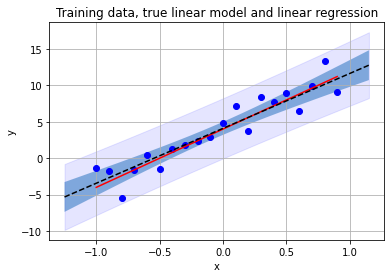

In [51]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,XX_te.dot(mu_w_pos),'--k');
plt.fill_between(x=x_te, y1=conf_f_vi[0], y2=conf_f_vi[1], alpha=0.5);
plt.fill_between(x=x_te, y1=conf_y_vi[0], y2=conf_y_vi[1], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

### Library: PyMC

Now that we have considered how it works, we are allowed to cheat... 

In [52]:
import pymc3 as pm

We will use the same model as for our Metropolis and VI implementation. This model may be implemented in PyMC as 

In [53]:
n_samp_pm = 500
pm_model = pm.Model()
with pm_model:
    # Define priors
    beta = pm.Gamma('beta', 2, 2)
    alpha0 = pm.Gamma('alpha0', 2, 2)
    alpha1 = pm.Gamma('alpha1', 2, 2)
    
    w0 = pm.Normal('w0', 0, sigma=(alpha0*beta)**(-0.5))
    w1 = pm.Normal('w1', 0, sigma=(alpha1*beta)**(-0.5))
    
    mu=w0 + w1 * x_tr
    sigma = beta**(-0.5)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_tr)

    # Inference!
    trace = pm.sample(n_samp_pm, cores=2) # draw 2000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w1, w0, alpha1, alpha0, beta]
Sampling 2 chains, 0 divergences: 100%|████████████████████████████████████████| 2000/2000 [00:02<00:00, 698.81draws/s]


Sample statistics and diagnostics; r_hat = 1 indicates convergence.

In [54]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
w0,4.10,0.45,3.26,4.94,0.02,0.01,843.0,821.0,839.0,583.0,1.0
w1,7.51,0.78,5.93,8.77,0.03,0.02,555.0,552.0,563.0,461.0,1.0
beta,0.28,0.09,0.13,0.46,0.00,0.00,763.0,763.0,747.0,705.0,1.0
alpha0,0.60,0.41,0.02,1.36,0.02,0.01,727.0,727.0,634.0,542.0,1.0
alpha1,0.29,0.23,0.02,0.72,0.01,0.01,880.0,765.0,855.0,651.0,1.0


Get the samples while regarding the first half as burn-in.

In [55]:
w0_pm = trace.get_values(varname='w0',burn=round(n_samp_pm/2))
w1_pm = trace.get_values(varname='w1',burn=round(n_samp_pm/2))
beta_pm = trace.get_values(varname='beta',burn=round(n_samp_pm/2))

print('Average standard deviation:', np.mean(beta_pm)**(-0.5))

Average standard deviation: 1.871298234474921


#### Prediction intervals

Bayesian credible interval for the mean (latent function) and output process:

In [56]:
f_pred_pm = np.vstack((w0_pm,w1_pm)).T.dot(XX_te.T)
y_pred_pm = f_pred_pm + np.random.normal(scale=np.sqrt(1/beta_pm)).reshape([-1,1])
mu_pred_f_pm = np.mean(f_pred_pm,axis=0)
cf_pred_f_pm= np.quantile(f_pred_pm,q=[0.025, 0.975],axis=0)
cf_pred_y_pm= np.quantile(y_pred_pm,q=[0.025, 0.975],axis=0)

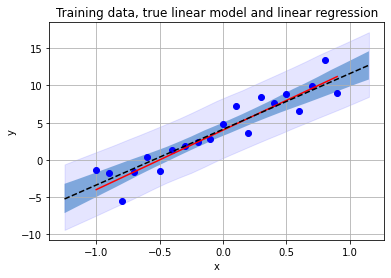

In [57]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.plot(x_te,mu_pred_f_pm,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f_pm[0,:], y2=cf_pred_f_pm[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y_pm[0,:], y2=cf_pred_y_pm[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();